## Генерация данных

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import numpy as np

num_towers = 50

# Настройка начальной и конечной даты
start_date = datetime(2024, 7, 5)
end_date = datetime(2024, 8, 26)

# Генерация временных меток с шагом в 1 час
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Задаём основном tower_id для каждого device_id
device_ids = list(range(100))
tower_ids = [f'tower_{i}' for i in range(50)]  # Простое сопоставление для примера

# Функция для выбора случайного tower_id, отличного от текущего
def get_random_tower_id(exclude_tower_id):
    available_towers = [t for t in tower_ids if t != exclude_tower_id]
    return random.choice(available_towers)

data = []

# Генерация базовых станций
towers = pd.DataFrame({
    'tower_id': range(num_towers),
    'latitude': np.random.uniform(55.0, 56.0, num_towers),
    'longitude': np.random.uniform(37.0, 38.0, num_towers),
    'radius': np.random.uniform(40, 100, num_towers),
})

# Присвоение стран и регионов
towers['country'] = 0
towers['region'] = 1

# Обновление стран и регионов для специальных групп
towers.loc[towers['latitude'].nsmallest(3).index, ['country', 'region']] = [1, 4]
towers.loc[towers['latitude'].nlargest(7).index, 'region'] = 2
towers.loc[towers['longitude'].nsmallest(5).index, 'region'] = 3

towers['tower_id'] = 'tower_' + towers['tower_id'].astype(str)

# Обработка событий для каждого device_id
for device_id in device_ids:
    if (device_id // 2) == 0:
      selected_tower = device_id//2
    else:
      selected_tower = device_id//2
    current_tower_id = tower_ids[selected_tower]

    for timestamp in timestamps:
        if device_id in range(11, 21):
            if random.random() < 0.02:
                current_tower_id = get_random_tower_id(current_tower_id)
            else:
                current_tower_id = tower_ids[device_id]

        elif device_id in range(21, 31):
            if random.random() < 0.05:
                current_tower_id = get_random_tower_id(current_tower_id)

        elif device_id in range(31, 41):
            if random.random() < 0.1:
                current_tower_id = get_random_tower_id(current_tower_id)
            elif random.random() < 0.05:
                current_tower_id = tower_ids[device_id]

        elif device_id in range(41, 50):
            if random.random() < 0.06:
                current_tower_id = get_random_tower_id(current_tower_id)
            elif random.random() < 0.03:
                current_tower_id = tower_ids[device_id]

        # Добавление записи в данные
        data.append({
            'timestamp': timestamp,
            'device_id': device_id,
            'tower_id': current_tower_id
        })

# Преобразование данных в DataFrame для анализа
df = pd.DataFrame(data)

merged_df = pd.merge(df, towers, on='tower_id', how='inner')

<ipython-input-1-b9378d01f07c>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq='H')


In [ ]:
merged_df

,timestamp,device_id,tower_id,latitude,longitude,radius,country,region
0,2024-07-05 00:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1
1,2024-07-05 01:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1
2,2024-07-05 02:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1
3,2024-07-05 03:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1
4,2024-07-05 04:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1
...,...,...,...,...,...,...,...,...
124895,2024-08-25 20:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1
124896,2024-08-25 21:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1
124897,2024-08-25 22:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1
124898,2024-08-25 23:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1


In [ ]:
merged_df.columns

Index(['timestamp', 'device_id', 'tower_id', 'latitude', 'longitude', 'radius',
       'country', 'region'],
      dtype='object')

In [ ]:
from geopy.distance import geodesic
from datetime import timedelta

def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

# Инициализация колонки для шансов аномалий
merged_df['anomaly_chance'] = 0

# Группировка данных по устройству
for device_id, group in merged_df.groupby('device_id'):
    group = group.sort_values('timestamp')

    # Переменные для хранения предыдущих значений
    last_tower = None
    last_timestamp = None
    three_days_switches = 0
    one_day_switches = 0
    last_tower_id = None
    last_country = None
    last_region = None

    for index, row in group.iterrows():
        anomaly_chance = 0

        # Проверка изменений региона и страны
        if last_tower_id is not None and row['tower_id'] != last_tower_id:
            anomaly_chance += 1  # +1%

            # row['region_change'] = 1
            merged_df.at[index, 'tower_change'] = 1
        else:
            # row['region_change'] = 0
            merged_df.at[index, 'tower_change'] = 0

        # Проверка первого подключения на неделю
        if last_tower is None or (row['timestamp'] - last_timestamp >= timedelta(weeks=1)):
            anomaly_chance += 2  # +2%

            # row['first_connection_weekly'] = 1
            merged_df.at[index, 'first_connection_weekly'] = 1
        else:
            # row['first_connection_weekly'] = 0
            merged_df.at[index, 'first_connection_weekly'] = 0

        # Проверка изменений региона и страны
        if last_region is not None and row['region'] != last_region:
            anomaly_chance += 1  # +1%

            # row['region_change'] = 1
            merged_df.at[index, 'region_change'] = 1
        else:
            # row['region_change'] = 0
            merged_df.at[index, 'region_change'] = 0

        if last_country is not None and row['country'] != last_country:
            anomaly_chance += 5  # +5%

            # row['country_change'] = 1
            merged_df.at[index, 'country_change'] = 1
        else:
            # row['country_change'] = 0
            merged_df.at[index, 'country_change'] = 0

        # Расчёт дистанции до прошлой вышки
        if last_tower is not None:
            distance = calculate_distance(
                row['latitude'], row['longitude'],
                last_tower['latitude'], last_tower['longitude']
            )
            anomaly_chance += distance * 0.01  # +0.01% за каждый км

            # row['distance'] = distance
            merged_df.at[index, 'distance'] = distance

            # Время с последнего подключения
            delta_hours = (row['timestamp'] - last_timestamp).total_seconds() / 3600
            if delta_hours == 1:
                anomaly_chance += 5  # +5%
            elif delta_hours in [2, 3]:
                anomaly_chance += 2  # +2%
            elif 4 <= delta_hours <= 10:
                anomaly_chance += 1  # +1%

            # row['delta_hours'] = delta_hours
            merged_df.at[index, 'delta_hours'] = delta_hours
        # else:

        #     row['distance'] = None

        #     row['delta_hours'] = None


        # Подсчет переключений
        if last_timestamp is not None and (row['timestamp'] - last_timestamp < timedelta(days=1)) and row['tower_id'] != last_tower_id:
            one_day_switches += 1
        else:
            one_day_switches = 0

        # row['one_day_switches'] = one_day_switches
        merged_df.at[index, 'one_day_switches'] = one_day_switches

        if last_timestamp is not None and (row['timestamp'] - last_timestamp < timedelta(days=3)) and row['tower_id'] != last_tower_id:
            three_days_switches += 1
        else:
            three_days_switches = 0

        # row['three_days_switches'] = three_days_switches
        merged_df.at[index, 'three_days_switches'] = three_days_switches

        # Проверка на количество переключений
        if one_day_switches == 0:
            anomaly_chance += 1  # +1%
        if three_days_switches == 0:
            anomaly_chance += 3  # +3%
        elif three_days_switches <= 2:
            anomaly_chance += 2  # +2%

        # Запись шанса аномалии в DataFrame
        merged_df.at[index, 'anomaly_chance'] = anomaly_chance

        # Update last_tower, last_timestamp, last_region, last_country
        last_tower = row
        last_timestamp = row['timestamp']
        last_tower_id = row['tower_id']
        last_region = row['region']
        last_country = row['country']

<ipython-input-4-c90879f99e50>:120: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.842439909292196' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.at[index, 'anomaly_chance'] = anomaly_chance


In [ ]:
merged_df

,timestamp,device_id,tower_id,latitude,longitude,radius,country,region,anomaly_chance,tower_change,first_connection_weekly,region_change,country_change,one_day_switches,three_days_switches,distance,delta_hours
0,2024-07-05 00:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,6.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,2024-07-05 01:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2024-07-05 02:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2024-07-05 03:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2024-07-05 04:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,2024-08-25 20:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124896,2024-08-25 21:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124897,2024-08-25 22:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124898,2024-08-25 23:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='anomaly_chance', ylabel='Count'>

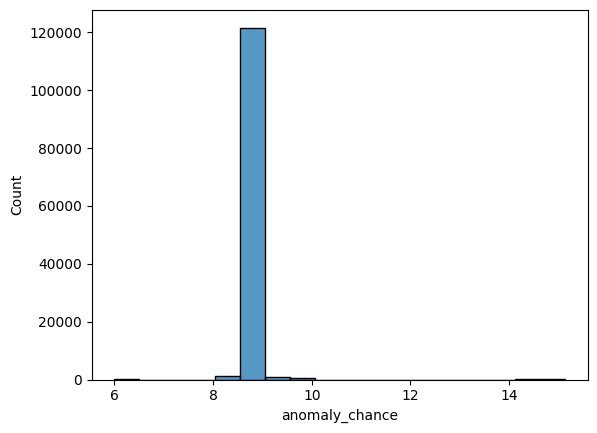

In [ ]:
import seaborn as sns

sns.histplot(merged_df['anomaly_chance'])

In [ ]:
def determine_anomaly(row):
    random_value = np.random.rand() * 100  # Генерируем случайное число от 0 до 100
    if random_value < row['anomaly_chance']:
        return 1
    else:
        return 0

# Применяем функцию к каждой строке DataFrame
merged_df['is_anomaly'] = merged_df.apply(determine_anomaly, axis=1)

In [ ]:
merged_df

,timestamp,device_id,tower_id,latitude,longitude,radius,country,region,anomaly_chance,tower_change,first_connection_weekly,region_change,country_change,one_day_switches,three_days_switches,distance,delta_hours,is_anomaly
0,2024-07-05 00:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,6.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0
1,2024-07-05 01:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,2024-07-05 02:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,2024-07-05 03:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,2024-07-05 04:00:00,0,tower_0,55.884002,37.888629,76.849701,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124895,2024-08-25 20:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
124896,2024-08-25 21:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
124897,2024-08-25 22:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
124898,2024-08-25 23:00:00,99,tower_49,55.825153,37.701472,50.045109,0,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [ ]:
merged_df['is_anomaly'].value_counts()

,count
is_anomaly,
0,113506
1,11394


In [ ]:
merged_df = merged_df.drop(['anomaly_chance'], axis = 1)

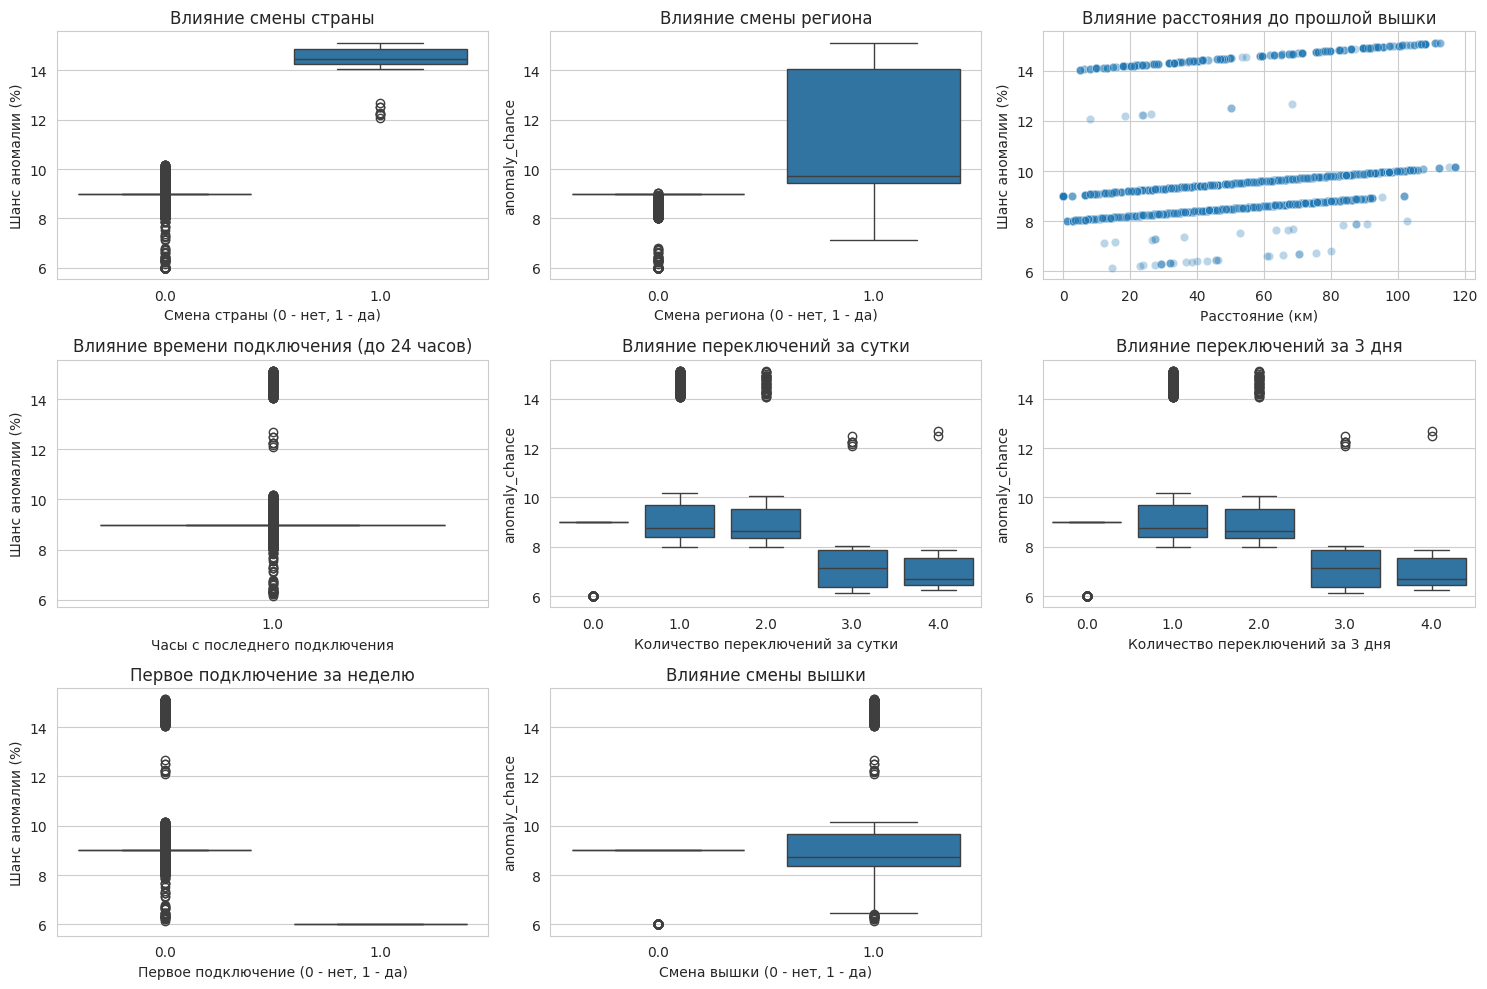

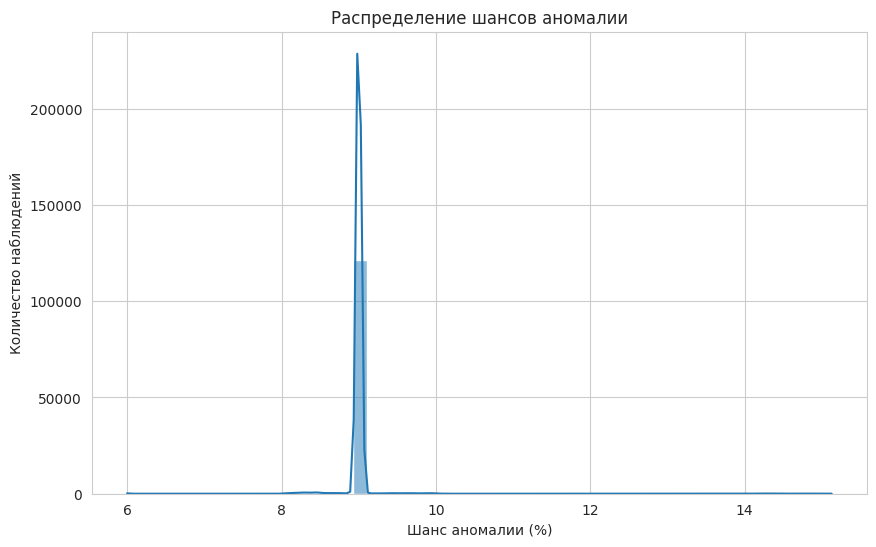

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установим стиль графиков
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Влияние смены страны на вероятность аномалии
plt.subplot(3, 3, 1)
sns.boxplot(x='country_change', y='anomaly_chance', data=merged_df)
plt.title('Влияние смены страны')
plt.xlabel('Смена страны (0 - нет, 1 - да)')
plt.ylabel('Шанс аномалии (%)')

# 2. Влияние смены региона на вероятность аномалии
plt.subplot(3, 3, 2)
sns.boxplot(x='region_change', y='anomaly_chance', data=merged_df)
plt.title('Влияние смены региона')
plt.xlabel('Смена региона (0 - нет, 1 - да)')

# 3. Влияние расстояния до предыдущей вышки
plt.subplot(3, 3, 3)
sns.scatterplot(x='distance', y='anomaly_chance', data=merged_df, alpha=0.3)
plt.title('Влияние расстояния до прошлой вышки')
plt.xlabel('Расстояние (км)')
plt.ylabel('Шанс аномалии (%)')

# 4. Влияние времени подключения к прошлой вышке
plt.subplot(3, 3, 4)
sns.boxplot(x='delta_hours', y='anomaly_chance', data=merged_df[merged_df['delta_hours'] <= 24])
plt.title('Влияние времени подключения (до 24 часов)')
plt.xlabel('Часы с последнего подключения')
plt.ylabel('Шанс аномалии (%)')

# 5. Влияние переключений за сутки
plt.subplot(3, 3, 5)
sns.boxplot(x='one_day_switches', y='anomaly_chance', data=merged_df[merged_df['one_day_switches'] <= 5])
plt.title('Влияние переключений за сутки')
plt.xlabel('Количество переключений за сутки')

# 6. Влияние переключений за 3 дня
plt.subplot(3, 3, 6)
sns.boxplot(x='three_days_switches', y='anomaly_chance', data=merged_df[merged_df['three_days_switches'] <= 10])
plt.title('Влияние переключений за 3 дня')
plt.xlabel('Количество переключений за 3 дня')

# 7. Влияние первого подключения за неделю
plt.subplot(3, 3, 7)
sns.boxplot(x='first_connection_weekly', y='anomaly_chance', data=merged_df)
plt.title('Первое подключение за неделю')
plt.xlabel('Первое подключение (0 - нет, 1 - да)')
plt.ylabel('Шанс аномалии (%)')

# 8. Влияние смены вышки
plt.subplot(3, 3, 8)
sns.boxplot(x='tower_change', y='anomaly_chance', data=merged_df)
plt.title('Влияние смены вышки')
plt.xlabel('Смена вышки (0 - нет, 1 - да)')

plt.tight_layout()
plt.show()

# 9. Общее распределение шансов аномалии
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['anomaly_chance'], bins=50, kde=True)
plt.title('Распределение шансов аномалии')
plt.xlabel('Шанс аномалии (%)')
plt.ylabel('Количество наблюдений')
plt.show()

<ipython-input-22-5279198a135f>:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=merged_df, x=feature, hue='is_anomaly', common_norm=False, fill=True)


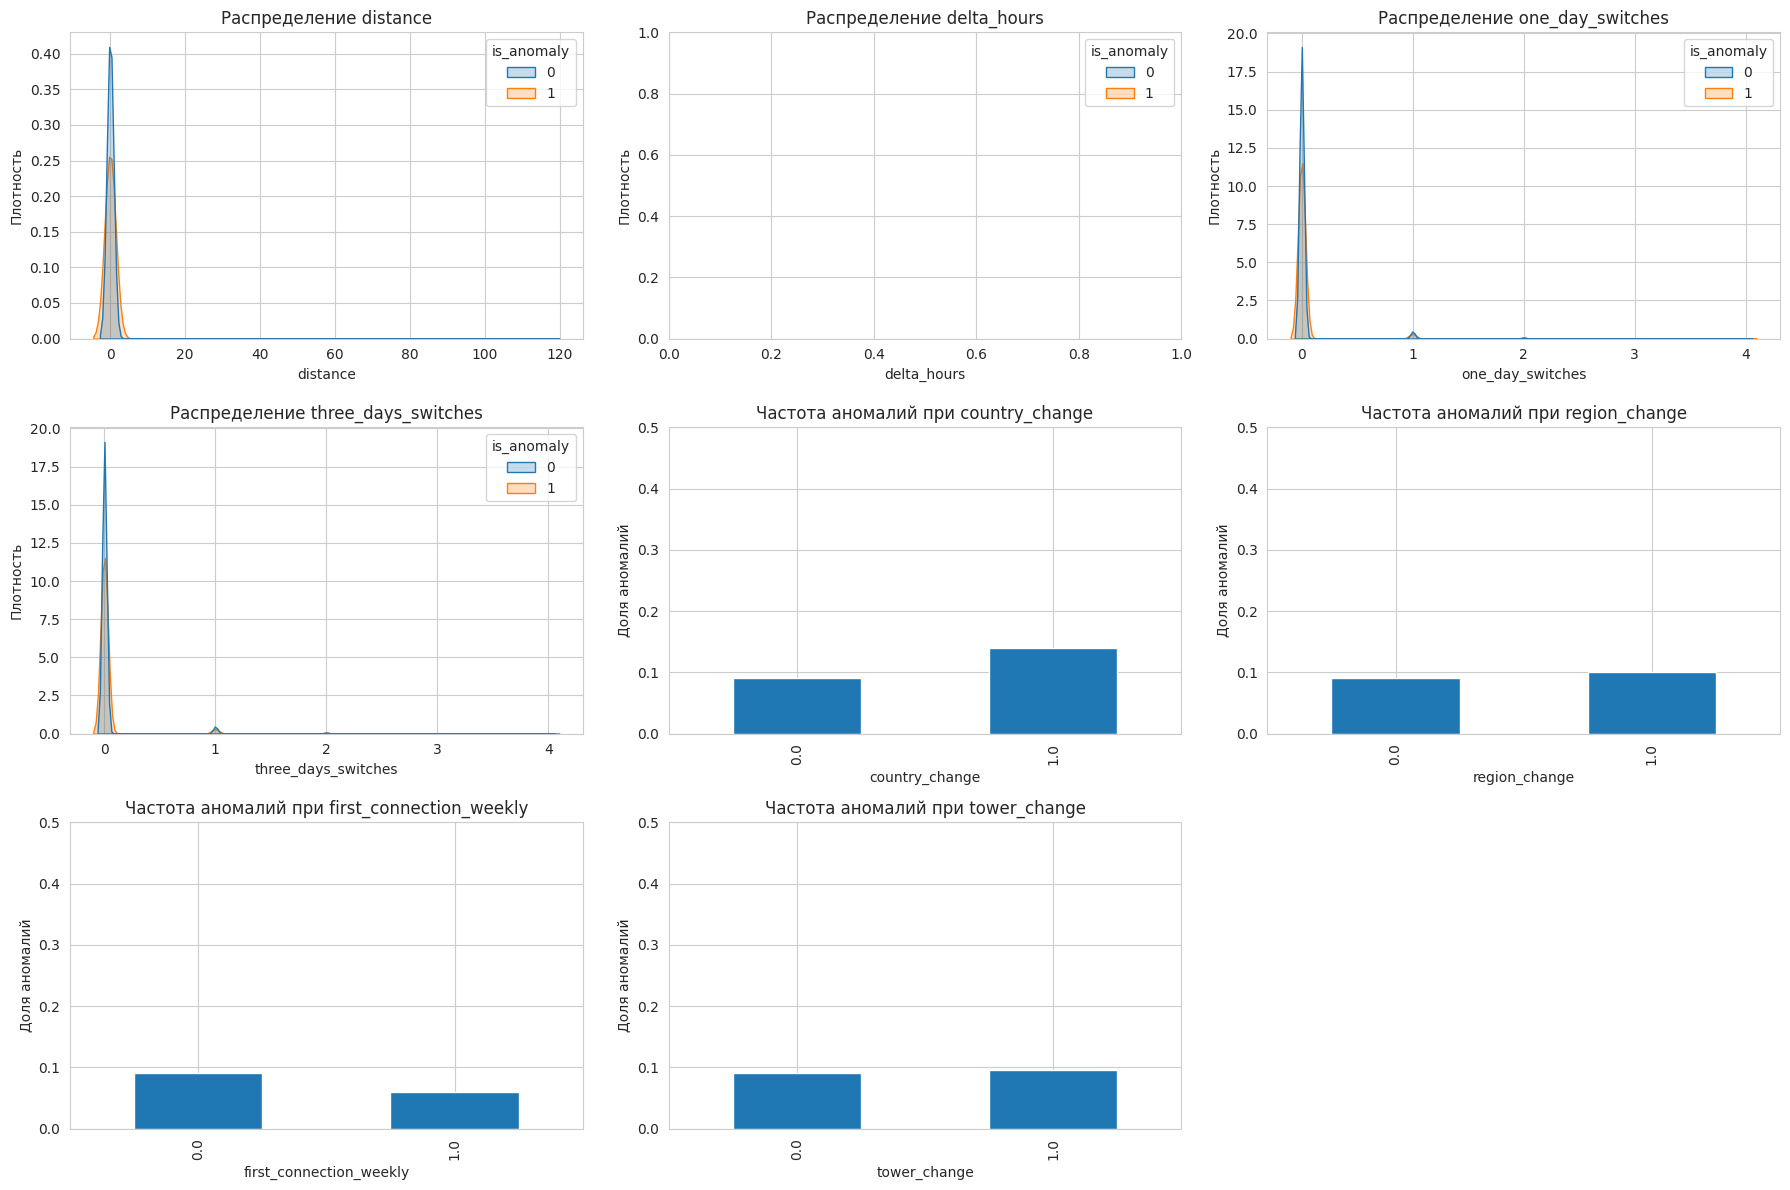

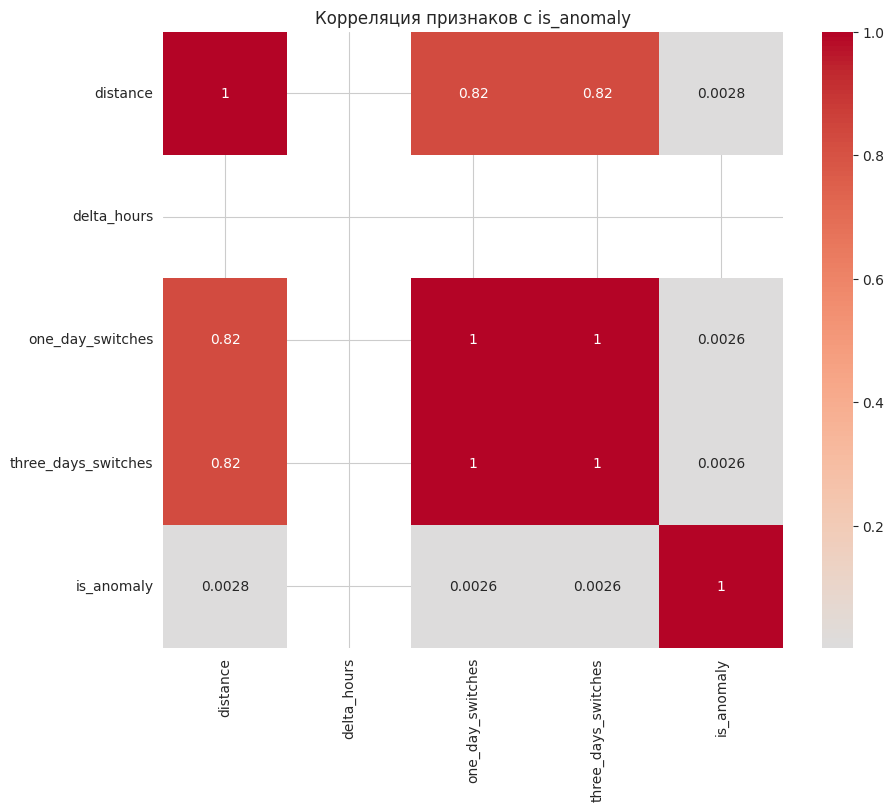

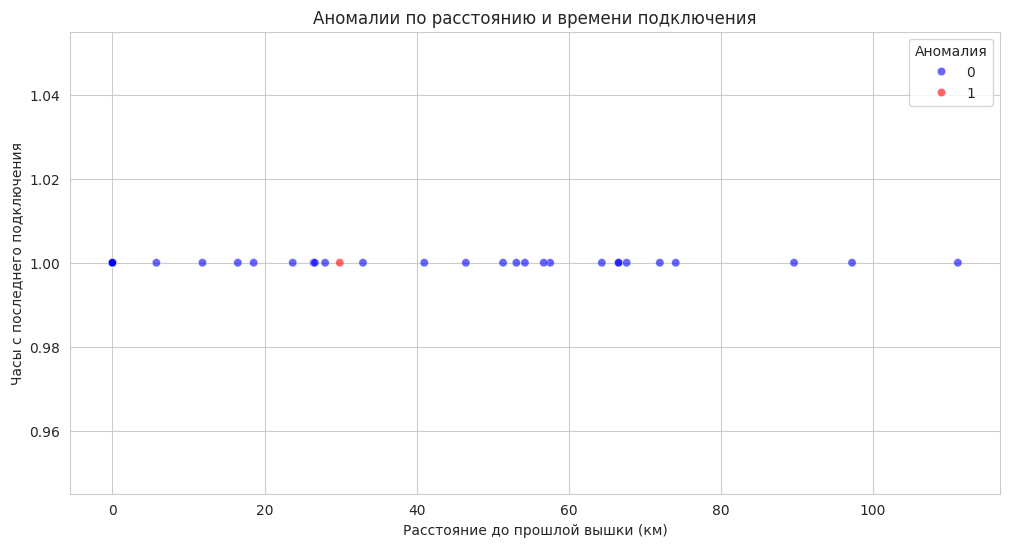

In [ ]:
plt.figure(figsize=(18, 12))

# 1. Распределение числовых признаков для аномалий и нормальных данных
numeric_features = ['distance', 'delta_hours', 'one_day_switches', 'three_days_switches']

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=merged_df, x=feature, hue='is_anomaly', common_norm=False, fill=True)
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Плотность')

# 2. Частота аномалий для бинарных признаков
binary_features = ['country_change', 'region_change', 'first_connection_weekly', 'tower_change']

for i, feature in enumerate(binary_features, len(numeric_features)+1):
    plt.subplot(3, 3, i)
    merged_df.groupby(feature)['is_anomaly'].mean().plot(kind='bar')
    plt.title(f'Частота аномалий при {feature}')
    plt.xlabel(feature)
    plt.ylabel('Доля аномалий')
    plt.ylim(0, 0.5)

plt.tight_layout()
plt.show()

# 3. Матрица корреляций (только для числовых признаков)
plt.figure(figsize=(10, 8))
corr_matrix = merged_df[numeric_features + ['is_anomaly']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция признаков с is_anomaly')
plt.show()

# 4. Точечный график для расстояния и времени подключения с цветом по аномалиям
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_df.sample(1000), x='distance', y='delta_hours',
                hue='is_anomaly', alpha=0.6, palette={0: 'blue', 1: 'red'})
plt.title('Аномалии по расстоянию и времени подключения')
plt.xlabel('Расстояние до прошлой вышки (км)')
plt.ylabel('Часы с последнего подключения')
plt.legend(title='Аномалия')
plt.show()